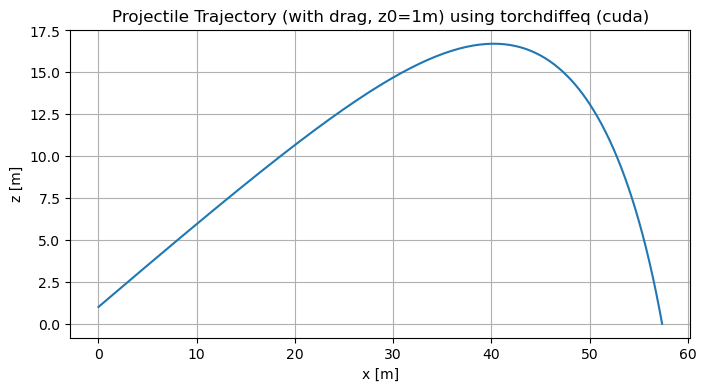

In [10]:
import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Parameters
g = 9.81      # m/s^2
k = 0.05      # drag coefficient (kg/m)
m = 1.0       # mass (kg)

# Ballistics ODE system
class BallisticsODE(torch.nn.Module):
    def forward(self, t, y):
        vel = y[3:]
        speed = torch.norm(vel)
        acc = torch.zeros_like(vel)
        acc[2] = -g
        acc -= (k/m) * speed * vel
        return torch.cat([vel, acc])

# Initial conditions -- launch from 1 meter above ground!
r0 = torch.tensor([0., 0., 1.], device=device)
v0 = torch.tensor([120., 0., 60.], device=device)
y0 = torch.cat([r0, v0]).to(device)

# Time points to evaluate (0 .. 15 seconds)
t = torch.linspace(0, 15, 1000).to(device)

# Solve ODE
odefunc = BallisticsODE().to(device)
sol = odeint(odefunc, y0, t)

# Retrieve results
z = sol[:,2].cpu().numpy()
x = sol[:,0].cpu().numpy()
y = sol[:,1].cpu().numpy()
t_cpu = t.cpu().numpy()

# Find where the projectile hits the ground (z <= 0)
idx_ground = (z <= 0)
if idx_ground.any():
    impact_idx = idx_ground.argmax()  # first index where z <= 0
    # Linear interpolation to improve landing point
    z1, z0 = z[impact_idx], z[impact_idx-1]
    x1, x0 = x[impact_idx], x[impact_idx-1]
    y1, y0 = y[impact_idx], y[impact_idx-1]
    t1, t0 = t_cpu[impact_idx], t_cpu[impact_idx-1]

    frac = -z0 / (z1 - z0)
    x_impact = x0 + frac * (x1 - x0)
    y_impact = y0 + frac * (y1 - y0)
    z_impact = 0.0

    # Truncate and append interpolated point
    x_plot = list(x[:impact_idx])
    y_plot = list(y[:impact_idx])
    z_plot = list(z[:impact_idx])
    x_plot.append(x_impact)
    y_plot.append(y_impact)
    z_plot.append(z_impact)
else:
    # Never hit the ground: plot everything
    x_plot = x
    y_plot = y
    z_plot = z

# Plot, only if there are at least 2 points!
if len(x_plot) >= 2:
    plt.figure(figsize=(8,4))
    plt.plot(x_plot, z_plot)
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    plt.title(f'Projectile Trajectory (with drag, z0=1m) using torchdiffeq ({device})')
    plt.grid()
    plt.show()
else:
    print("Projectile never left the ground (or landed at first step). No trajectory to plot.")

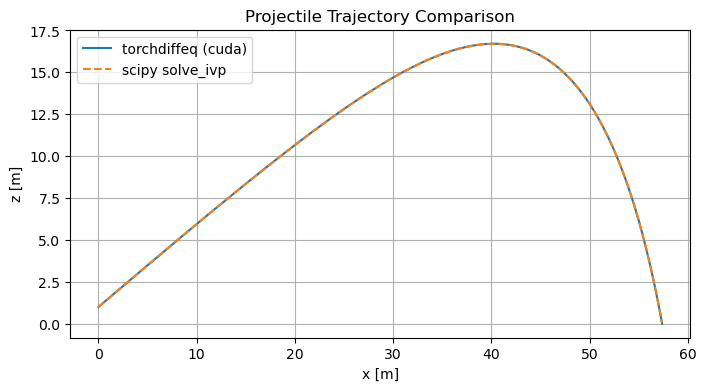

solve_ivp time:      25.54 ms
torchdiffeq time:    749.86 ms  (device: cuda)


In [11]:
import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
import time

# ----- Parameters -----
g = 9.81
k = 0.05
m = 1.0
r0 = np.array([0., 0., 1.])
v0 = np.array([120., 0., 60.])
y0_np = np.concatenate([r0, v0])

# ODE function for scipy
def ballistics_ode(t, y):
    vel = y[3:]
    speed = np.linalg.norm(vel)
    acc = np.zeros_like(vel)
    acc[2] = -g
    acc -= (k/m) * speed * vel
    return np.concatenate([vel, acc])

# ----- Solve with solve_ivp (and detect impact event) -----
def hit_ground_event(t, y):
    return y[2]
hit_ground_event.terminal = True
hit_ground_event.direction = -1

t_span = (0, 15)
t_eval = np.linspace(*t_span, 1000)

start = time.perf_counter()
sol_ivp = solve_ivp(
    ballistics_ode, t_span, y0_np, t_eval=t_eval,
    events=hit_ground_event, rtol=1e-7, atol=1e-9
)
time_ivp = time.perf_counter() - start

x_ivp, z_ivp = sol_ivp.y[0], sol_ivp.y[2]

# ----- Solve with torchdiffeq -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BallisticsODE(torch.nn.Module):
    def forward(self, t, y):
        vel = y[3:]
        speed = torch.norm(vel)
        acc = torch.zeros_like(vel)
        acc[2] = -g
        acc -= (k/m) * speed * vel
        return torch.cat([vel, acc])

r0_torch = torch.tensor([0., 0., 1.], device=device)
v0_torch = torch.tensor([120., 0., 60.], device=device)
y0 = torch.cat([r0_torch, v0_torch]).to(device)
t_torch = torch.linspace(0, 15, 1000).to(device)

odefunc = BallisticsODE().to(device)

torch.cuda.synchronize() if device.type == 'cuda' else None
start = time.perf_counter()
sol_torch = odeint(odefunc, y0, t_torch, rtol=1e-7, atol=1e-9)
torch.cuda.synchronize() if device.type == 'cuda' else None
time_torch = time.perf_counter() - start

sol_torch_cpu = sol_torch.cpu().detach().numpy()
x_torch, z_torch = sol_torch_cpu[:,0], sol_torch_cpu[:,2]

# Crop torchdiffeq output at ground (just like before)
z = z_torch
x = x_torch
idx_ground = (z <= 0)
if idx_ground.any():
    impact_idx = idx_ground.argmax()
    z1, z0 = z[impact_idx], z[impact_idx-1]
    x1, x0 = x[impact_idx], x[impact_idx-1]
    t1, t0 = t_torch[impact_idx].cpu().numpy(), t_torch[impact_idx-1].cpu().numpy()
    frac = -z0 / (z1 - z0)
    x_impact = x0 + frac * (x1 - x0)
    z_impact = 0.0
    x_plot = list(x[:impact_idx])
    z_plot = list(z[:impact_idx])
    x_plot.append(x_impact)
    z_plot.append(z_impact)
else:
    x_plot = x
    z_plot = z

# ----- Plot -----
plt.figure(figsize=(8,4))
plt.plot(x_plot, z_plot, label=f'torchdiffeq ({device})')
plt.plot(x_ivp, z_ivp, '--', label='scipy solve_ivp')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend()
plt.grid()
plt.title("Projectile Trajectory Comparison")
plt.show()

print(f"solve_ivp time:      {time_ivp*1e3:.2f} ms")
print(f"torchdiffeq time:    {time_torch*1e3:.2f} ms  (device: {device})")

In [12]:
import torch
from torchdiffeq import odeint
import numpy as np
from scipy.integrate import solve_ivp
import time

# Set batch size: increase this to see speedup on GPU
N = 10000

# Parameter ranges
np.random.seed(42)
r0 = np.zeros((N,3))
r0[:,2] = 1  # start at z=1m
# Random velocities: speed 100-140 m/s, angle 20-70 deg
speeds = np.random.uniform(100, 140, size=N)
angles = np.random.uniform(np.radians(20), np.radians(70), size=N)
azimuths = np.random.uniform(0, 2*np.pi, size=N)
v0 = np.zeros((N,3))
v0[:,0] = speeds * np.cos(angles) * np.cos(azimuths)
v0[:,1] = speeds * np.cos(angles) * np.sin(azimuths)
v0[:,2] = speeds * np.sin(angles)
# Random drag coefficients
k = np.random.uniform(0.03, 0.07, size=N)
m = 1.0
g = 9.81

# ----- torchdiffeq batch -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BallisticsODEBatch(torch.nn.Module):
    def __init__(self, k, m, g):
        super().__init__()
        # Expect k: (N,)
        self.k = torch.tensor(k, device=device).view(-1,1)
        self.m = m
        self.g = g
    def forward(self, t, y):
        # y: (batch, 6)
        vel = y[:,3:]
        speed = torch.norm(vel, dim=1, keepdim=True)
        acc = torch.zeros_like(vel)
        acc[:,2] -= self.g
        acc -= (self.k/self.m) * speed * vel
        return torch.cat([vel, acc], dim=1)

# Initial batch: (N,6)
y0 = np.hstack([r0, v0])
y0_torch = torch.tensor(y0, dtype=torch.float32, device=device)
t_torch = torch.linspace(0, 15, 300).to(device)

odefunc = BallisticsODEBatch(k, m, g).to(device)

torch.cuda.synchronize() if device.type=='cuda' else None
start = time.perf_counter()
sol_batch = odeint(odefunc, y0_torch, t_torch, rtol=1e-5, atol=1e-7)  # (T, N, 6)
torch.cuda.synchronize() if device.type=='cuda' else None
time_torch_batch = time.perf_counter() - start
print(f"torchdiffeq batch ({N} shots, {device}): {time_torch_batch:.3f} seconds")

# ----- solve_ivp loop -----
def ballistic_ivp_factory(ki):
    def fn(t, y):
        vel = y[3:]
        speed = np.linalg.norm(vel)
        acc = np.zeros_like(vel)
        acc[2] = -g
        acc -= (ki/m) * speed * vel
        return np.concatenate([vel, acc])
    return fn

t_eval = np.linspace(0, 15, 300)
y_final = np.empty((N, 6))
start = time.perf_counter()
for i in range(N):
    sol = solve_ivp(ballistic_ivp_factory(k[i]), (0,15), y0[i], t_eval=t_eval, rtol=1e-5, atol=1e-7)
    y_final[i] = sol.y[:,-1]
time_ivp_batch = time.perf_counter() - start
print(f"solve_ivp loop   ({N} shots, CPU): {time_ivp_batch:.3f} seconds")

# (optional) Show a few final ranges
final_x = sol_batch[-1,:,0].cpu().numpy()
final_z = sol_batch[-1,:,2].cpu().numpy()
print("Example simulated ranges (x where z is near ground):", final_x[:10])

torchdiffeq batch (10000 shots, cuda): 0.325 seconds
solve_ivp loop   (10000 shots, CPU): 80.503 seconds
Example simulated ranges (x where z is near ground): [ -6.278803   24.221395  -26.711138  -30.943447  -47.362797   -2.1689377
  47.344044   37.749157   -9.140611    5.94443  ]


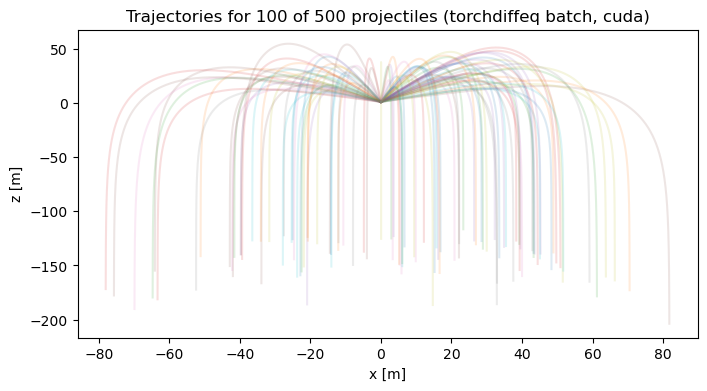

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sample = min(100, N)
T = sol_batch.size(0)
for i in range(sample):
    x = sol_batch[:,i,0].cpu().numpy()
    z = sol_batch[:,i,2].cpu().numpy()
    plt.plot(x, z, alpha=0.15)
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title(f"Trajectories for {sample} of {N} projectiles (torchdiffeq batch, {device})")
plt.show()

torchdiffeq batch (5000 shots, cuda): 0.375 seconds


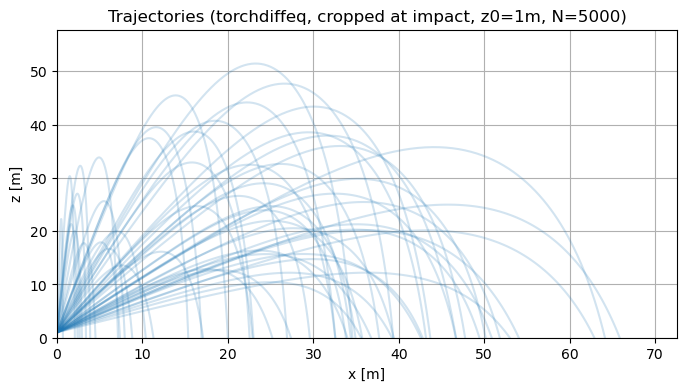

torchdiffeq batch (5000 shots, cuda): 0.375 seconds
solve_ivp loop   (5000 shots, CPU): 29.054 seconds


In [34]:
import torch
from torchdiffeq import odeint
import numpy as np
from scipy.integrate import solve_ivp
import time
import matplotlib.pyplot as plt

# Batch size
N = 5000  # you can set N=10000 for pure timings; use smaller for plotting demos

# Parameter ranges
np.random.seed(42)
r0 = np.zeros((N,3))
r0[:,2] = 1  # start at z=1m
speeds = np.random.uniform(100, 140, size=N)
angles = np.random.uniform(np.radians(20), np.radians(70), size=N)
azimuths = np.random.uniform(0, 2*np.pi, size=N)
v0 = np.zeros((N,3))
v0[:,0] = speeds * np.cos(angles) * np.cos(azimuths)
v0[:,1] = speeds * np.cos(angles) * np.sin(azimuths)
v0[:,2] = speeds * np.sin(angles)
k = np.random.uniform(0.03, 0.07, size=N)
m = 1.0
g = 9.81

# ----- torchdiffeq batch -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BallisticsODEBatch(torch.nn.Module):
    def __init__(self, k, m, g):
        super().__init__()
        self.k = torch.tensor(k, device=device).view(-1,1)
        self.m = m
        self.g = g
    def forward(self, t, y):
        vel = y[:,3:]
        speed = torch.norm(vel, dim=1, keepdim=True)
        acc = torch.zeros_like(vel)
        acc[:,2] -= self.g
        acc -= (self.k/self.m) * speed * vel
        return torch.cat([vel, acc], dim=1)

# Initial (N,6)
y0 = np.hstack([r0, v0])
y0_torch = torch.tensor(y0, dtype=torch.float32, device=device)
t_points = 400
t_torch = torch.linspace(0, 15, t_points).to(device)
odefunc = BallisticsODEBatch(k, m, g).to(device)

torch.cuda.synchronize() if device.type=='cuda' else None
start = time.perf_counter()
sol_batch = odeint(odefunc, y0_torch, t_torch, rtol=1e-5, atol=1e-7)  # (T, N, 6)
torch.cuda.synchronize() if device.type=='cuda' else None
time_torch_batch = time.perf_counter() - start

print(f"torchdiffeq batch ({N} shots, {device}): {time_torch_batch:.3f} seconds")

# ---- Crop trajectories at ground for plotting ----
sol_batch_np = sol_batch.cpu().numpy()  # (T, N, 6)
t_np = t_torch.cpu().numpy()

def crop_trajectory(x, z, t):
    """Find ground crossing and interpolate last point to z=0"""
    idx = np.where(z <= 0)[0]
    if len(idx)==0:
        # never crossed ground, return full trajectory
        return x, z
    i = idx[0]
    if i==0:
        return x[:1], z[:1]
    # interpolate last segment to z=0
    x0, z0, t0 = x[i-1], z[i-1], t[i-1]
    x1, z1, t1 = x[i], z[i], t[i]
    frac = -z0 / (z1 - z0)
    x_impact = x0 + frac * (x1 - x0)
    z_impact = 0.
    # return trajectory up to impact
    x_cropped = np.concatenate([x[:i], [x_impact]])
    z_cropped = np.concatenate([z[:i], [z_impact]])
    return x_cropped, z_cropped

# Plot several trajectories (all stop at z=0)
plt.figure(figsize=(8,4))
for i in range(min(100, N)):
    x = sol_batch_np[:,i,0]
    z = sol_batch_np[:,i,2]
    x_c, z_c = crop_trajectory(x, z, t_np)
    plt.plot(x_c, z_c, alpha=0.2, color='tab:blue')
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title(f"Trajectories (torchdiffeq, cropped at impact, z0=1m, N={N})")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()
plt.show()

# ---- solve_ivp demo on one of the projectiles ----
def ballistic_ivp_factory(ki):
    def fn(t, y):
        vel = y[3:]
        speed = np.linalg.norm(vel)
        acc = np.zeros_like(vel)
        acc[2] = -g
        acc -= (ki/m) * speed * vel
        return np.concatenate([vel, acc])
    return fn
def hit_ground_event(t, y):
    return y[2]
hit_ground_event.terminal = True
hit_ground_event.direction = -1
t_eval = np.linspace(0, 15, t_points)

# pick random index
i_probe = np.random.choice(N)
sol = solve_ivp(ballistic_ivp_factory(k[i_probe]), (0,15), y0[i_probe], t_eval=t_eval, rtol=1e-5, atol=1e-7, events=hit_ground_event)
x_ivp, z_ivp = sol.y[0], sol.y[2]

# Optionally crop the torchdiffeq trajectory for this same projectile
x_torch = sol_batch_np[:,i_probe,0]
z_torch = sol_batch_np[:,i_probe,2]
x_torch_c, z_torch_c = crop_trajectory(x_torch, z_torch, t_np)



# Optional: print timings for larger N
print(f"torchdiffeq batch ({N} shots, {device}): {time_torch_batch:.3f} seconds")
start = time.perf_counter()
for i in range(N):
    solve_ivp(ballistic_ivp_factory(k[i]), (0,15), y0[i], t_eval=t_eval, rtol=1e-5, atol=1e-7, events=hit_ground_event)
time_ivp_batch = time.perf_counter() - start
print(f"solve_ivp loop   ({N} shots, CPU): {time_ivp_batch:.3f} seconds")

torchdiffeq batch (200 shots, cuda): 0.367 seconds


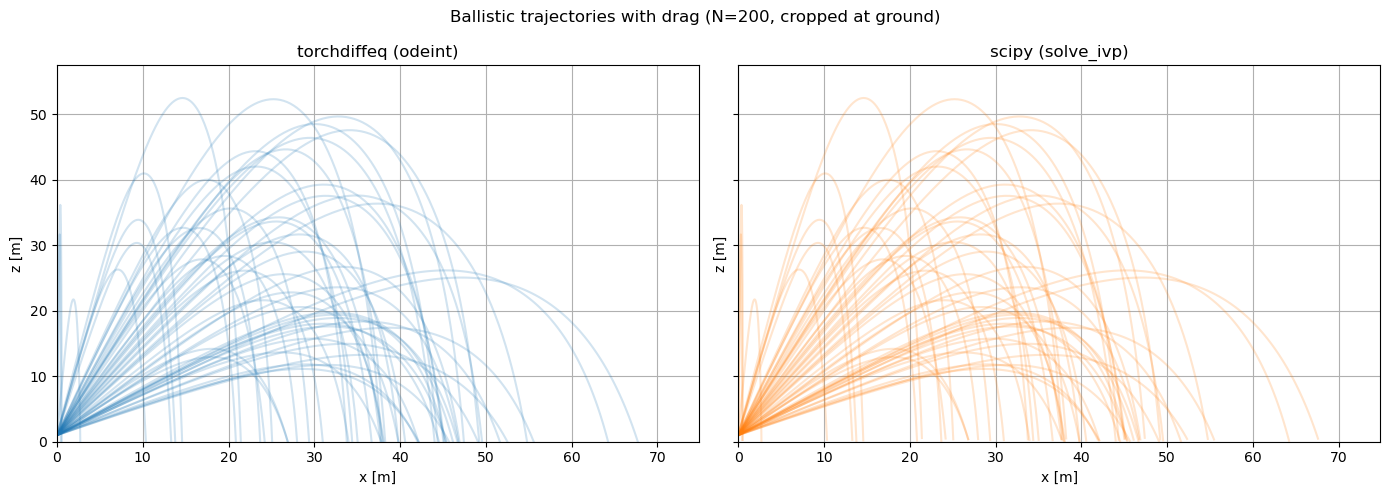

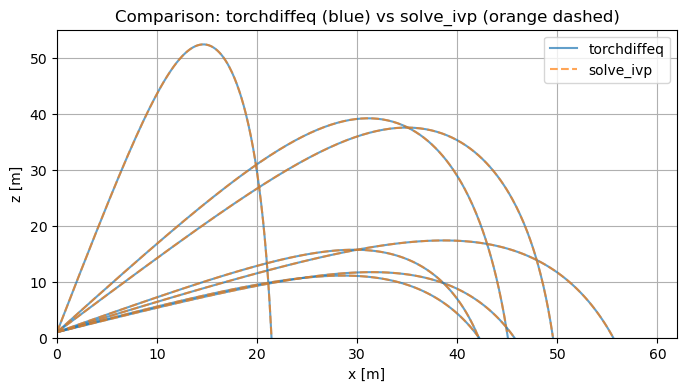

torchdiffeq batch (200 shots, cuda): 0.367 seconds
solve_ivp loop   (200 shots, CPU): 1.157 seconds


In [36]:
import torch
from torchdiffeq import odeint
import numpy as np
from scipy.integrate import solve_ivp
import time
import matplotlib.pyplot as plt

# --------- PARAMETERS AND INITIAL CONDITIONS ---------
# Batch size
N = 200  # set to 100-200 for plotting demos, higher for timing only

# Parameter ranges
np.random.seed(42)
r0 = np.zeros((N,3))
r0[:,2] = 1  # start at z=1m

speeds = np.random.uniform(100, 140, size=N)
angles = np.random.uniform(np.radians(20), np.radians(70), size=N)
azimuths = np.random.uniform(0, 2*np.pi, size=N)

v0 = np.zeros((N,3))
v0[:,0] = speeds * np.cos(angles) * np.cos(azimuths)
v0[:,1] = speeds * np.cos(angles) * np.sin(azimuths)
v0[:,2] = speeds * np.sin(angles)

k = np.random.uniform(0.03, 0.07, size=N)
m = 1.0
g = 9.81

# --------- TORCHDIFFEQ ODEINT BATCH ----------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BallisticsODEBatch(torch.nn.Module):
    def __init__(self, k, m, g):
        super().__init__()
        self.k = torch.tensor(k, device=device).view(-1,1)
        self.m = m
        self.g = g
    def forward(self, t, y):
        vel = y[:,3:]
        speed = torch.norm(vel, dim=1, keepdim=True)
        acc = torch.zeros_like(vel)
        acc[:,2] -= self.g
        acc -= (self.k/self.m) * speed * vel
        return torch.cat([vel, acc], dim=1)

# Initial condition, shape (N,6)
y0 = np.hstack([r0, v0])
y0_torch = torch.tensor(y0, dtype=torch.float32, device=device)
t_points = 400
t_torch = torch.linspace(0, 15, t_points).to(device)

odefunc = BallisticsODEBatch(k, m, g).to(device)

torch.cuda.synchronize() if device.type=='cuda' else None
start = time.perf_counter()
sol_batch = odeint(odefunc, y0_torch, t_torch, rtol=1e-5, atol=1e-7)  # (T, N, 6)
torch.cuda.synchronize() if device.type=='cuda' else None
time_torch_batch = time.perf_counter() - start
print(f"torchdiffeq batch ({N} shots, {device}): {time_torch_batch:.3f} seconds")

# Convert to numpy for plotting
sol_batch_np = sol_batch.cpu().numpy()  # (T, N, 6)
t_np = t_torch.cpu().numpy()

# --------- SOLVE_IVP (scipy) SINGLE TRAJECTORY AND BATCH LOOPS ----------

def ballistic_ivp_factory(ki):
    def fn(t, y):
        vel = y[3:]
        speed = np.linalg.norm(vel)
        acc = np.zeros_like(vel)
        acc[2] = -g
        acc -= (ki/m) * speed * vel
        return np.concatenate([vel, acc])
    return fn

def hit_ground_event(t, y):
    return y[2]
hit_ground_event.terminal = True
hit_ground_event.direction = -1

t_eval = np.linspace(0, 15, t_points)

# --------- FUNCTION: CROP TRAJECTORY AT GROUND -----------
def crop_trajectory(x, z, t):
    """Find ground crossing, interpolate last point to z=0"""
    idx = np.where(z <= 0)[0]
    if len(idx) == 0:
        return x, z
    i = idx[0]
    if i == 0:
        return x[:1], z[:1]
    x0, z0, t0 = x[i-1], z[i-1], t[i-1]
    x1, z1, t1 = x[i], z[i], t[i]
    frac = -z0 / (z1 - z0)
    x_impact = x0 + frac * (x1 - x0)
    z_impact = 0.
    # Return trajectory up to impact
    x_cropped = np.concatenate([x[:i], [x_impact]])
    z_cropped = np.concatenate([z[:i], [z_impact]])
    return x_cropped, z_cropped

# --------- PLOTS ---------

# ----- Side-by-side plots for both methods ------
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)

# Plot torchdiffeq results
for i in range(min(100, N)):
    x = sol_batch_np[:,i,0]
    z = sol_batch_np[:,i,2]
    x_c, z_c = crop_trajectory(x, z, t_np)
    axs[0].plot(x_c, z_c, alpha=0.2, color='tab:blue')
axs[0].set_title("torchdiffeq (odeint)")
axs[0].set_xlabel("x [m]")
axs[0].set_ylabel("z [m]")
axs[0].set_xlim(left=0)
axs[0].set_ylim(bottom=0)
axs[0].grid()

# Plot solve_ivp results
for i in range(min(100, N)):
    sol = solve_ivp(
        ballistic_ivp_factory(k[i]), (0, 15), y0[i],
        t_eval=t_eval, rtol=1e-5, atol=1e-7, events=hit_ground_event)
    x, z = sol.y[0], sol.y[2]
    x_c, z_c = crop_trajectory(x, z, sol.t)
    axs[1].plot(x_c, z_c, alpha=0.2, color='tab:orange')
axs[1].set_title("scipy (solve_ivp)")
axs[1].set_xlabel("x [m]")
axs[1].set_ylabel("z [m]")
axs[1].set_xlim(left=0)
axs[1].set_ylim(bottom=0)
axs[1].grid()

plt.suptitle(f"Ballistic trajectories with drag (N={N}, cropped at ground)")
plt.tight_layout()
plt.show()

# --------- OPTIONAL: Overlay plots for direct comparison (first 10 projectiles) ---------
plt.figure(figsize=(8, 4))
for i in range(min(10, N)):
    # Torchdiffeq
    x_t, z_t = sol_batch_np[:,i,0], sol_batch_np[:,i,2]
    x_tc, z_tc = crop_trajectory(x_t, z_t, t_np)
    plt.plot(x_tc, z_tc, alpha=0.7, color='tab:blue', label='torchdiffeq' if i==0 else None)
    # Scipy
    sol = solve_ivp(
        ballistic_ivp_factory(k[i]), (0, 15), y0[i],
        t_eval=t_eval, rtol=1e-5, atol=1e-7, events=hit_ground_event)
    x_s, z_s = sol.y[0], sol.y[2]
    x_sc, z_sc = crop_trajectory(x_s, z_s, sol.t)
    plt.plot(x_sc, z_sc, '--', alpha=0.7, color='tab:orange', label='solve_ivp' if i==0 else None)
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title("Comparison: torchdiffeq (blue) vs solve_ivp (orange dashed)")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.grid()
plt.show()

# --------- TIMINGS (shown in print above for torchdiffeq) ---------
print(f"torchdiffeq batch ({N} shots, {device}): {time_torch_batch:.3f} seconds")
start = time.perf_counter()
for i in range(N):
    solve_ivp(ballistic_ivp_factory(k[i]), (0,15), y0[i], t_eval=t_eval, rtol=1e-5, atol=1e-7, events=hit_ground_event)
time_ivp_batch = time.perf_counter() - start
print(f"solve_ivp loop   ({N} shots, CPU): {time_ivp_batch:.3f} seconds")